<a href="https://colab.research.google.com/github/alegoritma/CSE-ImageProcessing-Project/blob/main/Optic_Disc_Segmentation_Training_(Unet_%2B_EfficientNet)_%5BRIGA%2BREFUGE_v1%5D_Custom_Loss_on_TPU_CROPPED_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
%%capture
!pip install gcsfs

import os, sys, math
import numpy as np
import pandas as pd
import gcsfs
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *

from IPython.display import clear_output
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

import collections
import math
import string

from math import sqrt

keras.backend.clear_session()
tf.__version__

Tensorflow version 2.4.0


'2.4.0'

In [ ]:
#@title Authentication
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Activate TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.42.66.178:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.42.66.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.66.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
PROJECT_ID = "Hidden due to privacy issues!"

In [ ]:
GCS_OUTPUT = f'gs://{PROJECT_ID}/cup-to-disc/tf-records/RIGA_cropped/'
VALIDATION = f'gs://{PROJECT_ID}/cup-to-disc/tf-records/REFUGE_cropped/'
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 2 * tpu_strategy.num_replicas_in_sync

TARGET_SIZE = [256, 256]

#### Custom U-Net Model with Efficientnet Backbone
For this part source code gathered from variaty of resources like [tensorflow docs](https://www.tensorflow.org/tutorials/images/segmentation)


In [ ]:
#@title Efficientnet Configs
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio', 'final_bn'
])

BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=False, strides=[1, 1], se_ratio=0.25,
              final_bn=False)
    
]

ENCODER_LAYERS = [ 'block2a', 'block3a', 'block4a',  'block6a']

In [ ]:
#@title Sequeeze and Excitation layer
class SEBlock(Layer):
    """Implementation of Squeeze and Excitation network"""
    def __init__(self, name, filters, ratio, kernel_initializer, 
                    activation=tf.nn.swish):
        super(SEBlock, self).__init__(name)

        self.squeeze = GlobalAveragePooling2D(name='se_squeeze')
        self.reduce = Conv2D(filters * ratio, 
                                kernel_size=1,
                                activation=activation, 
                                padding='same',
                                use_bias=True,
                                kernel_initializer=kernel_initializer,
                                name='se_reduce')

        self.expand = Conv2D(filters, 
                                kernel_size=1,
                                activation='sigmoid',
                                padding='same',
                                use_bias=True,
                                kernel_initializer=kernel_initializer,
                                name='se_expand')

    def call(self, input):
        x = self.squeeze(input)
        channels = x.shape[-1]
        x = tf.reshape(x, (-1, 1, 1, channels))
        x = self.reduce(x)
        x = self.expand(x)
        return x

In [ ]:
#@title Mobile inverted convolution Layer
class MBConvBlock(Layer):
    def __init__(self, block_args, kernel_initializer, drop_rate=None, 
                 name='', activation=tf.nn.swish):
        super(MBConvBlock, self).__init__(name=name)
        filters = block_args.input_filters * block_args.expand_ratio
        self.block_args = block_args
        if block_args.expand_ratio != 1:
            self.expand_conv = Conv2D(filters, 1, padding='same', 
                                        use_bias=False,
                                        kernel_initializer=kernel_initializer,
                                        name='expand_cov')
            self.expand_bn = BatchNormalization(axis=3, name='expand_bn')
            self.expand_act = Activation(activation, name='expand_activation')

        self.depth_conv = DepthwiseConv2D(block_args.kernel_size,
                              strides=block_args.strides,
                              padding='same',
                              use_bias=False,
                              depthwise_initializer=kernel_initializer,
                              name='dwconv')
        self.depth_bn = BatchNormalization(axis=3, name='bn')
        self.depth_act = Activation(activation, name='activation')

        if block_args.se_ratio > 0:
            self.se_block = SEBlock('se', filters , block_args.se_ratio, 
                                    kernel_initializer)

        self.out_conv = Conv2D(block_args.output_filters, 1, 
                                padding='same',
                                use_bias=False,
                                kernel_initializer=kernel_initializer,
                                name='project')
        
        self.out_bn =  BatchNormalization(axis=3, name='project_bn')

    def call(self, input, training):
        x = input
        enc = None
        if self.block_args.expand_ratio != 1:
            x = self.expand_conv(x)
            x = self.expand_bn(x)
            x = self.expand_act(x)
            enc = x

        x = self.depth_conv(x)
        x = self.depth_bn(x)
        x = self.depth_act(x)

        if self.block_args.se_ratio > 0:
            se = self.se_block(x)
            x = tf.math.multiply(x, se)

        x = self.out_conv(x)
        if self.block_args.final_bn:
          x = self.out_bn(x)

        if self.block_args.id_skip and \
              self.block_args.input_filters == self.block_args.output_filters:
            x = tf.math.add(x, input)

        return x, enc

In [ ]:
#@title Encoder EfficientNet
class EfficientNet(Layer):
    """Implementation of base Efficient net"""
    def __init__(self, width_coefficient, 
                    depth_coefficient, 
                    dropout_rate=0.2,
                    drop_connect_rate=0.2,
                    depth_divisor=8,
                    activation=tf.nn.swish,
                    blocks_args=DEFAULT_BLOCKS_ARGS,
                    encoder_layers=ENCODER_LAYERS,
                    layer_name='efficient_net',
                    weights='imagenet'):
      super(EfficientNet, self).__init__(layer_name)
      self.layer_name = layer_name
      self.block_args = blocks_args
      self.encoder_layers = encoder_layers
      

      #stem 
      self.stem_conv = Conv2D(self.round_filters(32, width_coefficient, depth_divisor), 3,
                              strides=(2,2),
                              padding='same',
                              use_bias=False,
                              kernel_initializer=CONV_KERNEL_INITIALIZER,
                              name='stem_conv')
      self.stem_bn = BatchNormalization(axis=3, name='stem_bn')
      self.stem_act = Activation(activation, name='stem_Activation')

      self.mb_blocks = {}
      for idx, block_args in enumerate(blocks_args):
          block_args = block_args._replace(
              input_filters=self.round_filters(block_args.input_filters,
                                      width_coefficient, depth_divisor),
              output_filters=self.round_filters(block_args.output_filters,
                                        width_coefficient, depth_divisor),
              num_repeat=self.round_repeats(block_args.num_repeat, depth_coefficient))
          self.mb_blocks.update({f'block{idx + 1}a' : 
                              MBConvBlock(block_args, CONV_KERNEL_INITIALIZER ,
                                  drop_rate=None, name=f'block{idx + 1}a')})
          if idx < (len(blocks_args) - 1):
            for bidx in range((block_args.num_repeat - 1)):
                block_prefix = f'block{idx + 1}{string.ascii_lowercase[bidx + 1]}'
                block_args = block_args._replace(input_filters=block_args.output_filters, 
                                                  strides=[1, 1])
                self.mb_blocks.update({block_prefix : MBConvBlock(block_args, 
                                            CONV_KERNEL_INITIALIZER,
                                            drop_rate=None, name=block_prefix)})
              


    def call(self, input, training=True):
      self.output_layers = []
      x = self.stem_conv(input)
      x = self.stem_bn(x)
      x = self.stem_act(x) # 64 * 64

      for key in self.mb_blocks.keys():
        block = self.mb_blocks[key] 
        x, enc = block(x, training) 
        if key in self.encoder_layers:
          self.output_layers.append(enc) # 64, 32, 16, 8, 4

      self.output_layers.append(x)
      return self.output_layers

    def get_config(self):
      return {'layer_name': self.layer_name}


    def round_filters(self, filters, width_coefficient, 
                            depth_divisor):
      """Round number of filters based on width multiplier."""
      filters *= width_coefficient
      new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
      new_filters = max(depth_divisor, new_filters)
      # Make sure that round down does not go down by more than 10%.
      if new_filters < 0.9 * filters:
          new_filters += depth_divisor
      return int(new_filters)

    def round_repeats(self, repeats, depth_coefficient):
      return int(math.ceil(depth_coefficient * repeats))


In [ ]:
#@title Decoder
class DecoderBlock(Layer):
    def __init__(self, filters1, filters2, name, kernel_size=3):
      super(DecoderBlock, self).__init__(name=name)

      self.conv_1 = Conv2D(filters1, kernel_size=1, name='conv_1')
      self.bn_1 = BatchNormalization(name='conv_bn_1')
      self.act_1 = Activation('relu', name='conv_relu_1')

      self.up = Conv2DTranspose(filters1, kernel_size, 
                      strides=(2, 2), padding='same', name='up')
      self.up_bn = BatchNormalization(name='up_bn')
      self.up_relu = Activation('relu', name='up_act')

      self.conv_2 = Conv2D(filters2, kernel_size=1, name='conv_2')
      self.bn_2 = BatchNormalization(name='conv_bn_2')
      self.act_2 = Activation('relu', name='conv_relu_2')


    def call(self, input):
      x = self.conv_1(input)
      x = self.bn_1(x)
      x = self.act_1(x)

      x = self.up(x)
      x = self.up_bn(x)
      x = self.up_relu(x)

      x = self.conv_2(x)
      x = self.bn_2(x)
      x = self.act_2(x)

      return x

class Decoder(Layer):
    def __init__(self, start_filters, name='decoder'):
      super(Decoder, self).__init__(name)
      name = name

      self.decoder4 = DecoderBlock(start_filters * 32, 
                                      start_filters * 16, name='decoder4', kernel_size=3)
      self.decoder3 = DecoderBlock(start_filters * 16, 
                                      start_filters * 8, name='decoder3', kernel_size=3)
      self.decoder2 = DecoderBlock(start_filters * 8, 
                                      start_filters * 4, name='decoder2', kernel_size=3)
      self.decoder1 = DecoderBlock(start_filters * 4, 
                                      start_filters * 2, name='decoder1', kernel_size=3)


    def call(self, encoder):
      #e0 - 64, e1 - 32, e2 - 16, e3 - 8, e4 - 4
      em, e4, e3, e2, e1 = encoder


      d4 = self.decoder4(em) # 8 -> 16
      d4 = tf.concat([d4, e4], axis=-1)

      
      d3 = self.decoder3(d4) # 16 -> 32
      d3 = tf.concat([d3, e3], axis=-1)

      d2 = self.decoder2(d3) # 32 -> 64
      d2 = tf.concat([d2, e2], axis=-1)

      d1 = self.decoder1(d2) # 64 -> 128
      d1 = tf.concat([d1, e1], axis=-1)
      
      return d1

In [ ]:
#@title Unet model wrappes all the layers
class UNet(Model):
    def __init__(self, name, width_coefficient=1, 
                                   depth_coefficient=1, num_classes=2):
        super(UNet, self).__init__(name=name)
        # self.name = name 
        start_filters = 16
        self.backbone = EfficientNet(width_coefficient=width_coefficient, 
                                     depth_coefficient=depth_coefficient)
        
        self.middle_conv = Conv2D(start_filters * 32, kernel_size=3, 
                                    padding='same', name='middle_conv')
        self.middle_bn = BatchNormalization(axis=3, name='middle_bn')
        self.middle_act = Activation('relu', name='middle_activation')

        self.decoder = Decoder(start_filters)

        self.out_conv = Conv2DTranspose(num_classes, 3, strides=2,
                            padding='same', name='out_conv')
        
        

    def call(self, input, training):
        encoders = self.backbone(input)
        e1, e2, e3, e4, e5 = encoders 

        # #middle block
        em = self.middle_conv(e5)
        em = self.middle_bn(em)
        em = self.middle_act(em) 

        encoders = [em, e4, e3, e2, e1]
        mask = self.decoder(encoders)

        mask = self.out_conv(mask)
    
        return mask


    def compile(self, optimizer, loss_fn, train_loss, test_loss,
                    metric):
      super(UNet, self).compile(optimizer, metrics=metric)
      self.optimizer = optimizer 
      self.loss_fn = loss_fn

      self.train_loss = train_loss
      self.test_loss = test_loss

  
    def train_step(self, data):
        images, mask = data 
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_fn(mask, predictions)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.compiled_metrics.update_state(mask, predictions)
        mean_iou = self.metrics[0]

        return {'loss': self.train_loss.result(), \
                    mean_iou.name: mean_iou.result()}


    def test_step(self, data):
        images, mask = data

        predictions = self(images, training=False)
        loss = self.loss_fn(mask, predictions)

        self.test_loss(loss)
        self.compiled_metrics.update_state(mask, predictions)
        mean_iou = self.metrics[0]

        return {'loss': self.test_loss.result(), \
                    mean_iou.name: mean_iou.result()}


In [ ]:
def display(display_list, text="", filename=None, test=False):
    plt.figure(figsize=(9, 9))

    title = ['Input Image', 'True Mask', 'Predicted Mask'] if not test else ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        im = display_list[i]
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        if hasattr(im, "numpy"): im = im.numpy()
        # if (title[i] == "Input Image"): im = (im*255)
        
        # im = im.astype(np.uint8)
        if (im.shape[-1] == 1): im = np.reshape(im, im.shape[:-1])
        

        plt.imshow(im)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.text(-560, 270, text)
    if filename:
        plt.savefig(f"{WORKING_FILE_NAME}/{filename}.png")
    else:    
        plt.show()

def show_predictions():
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#### Data pipe

In [ ]:

def read_tfrecord(example):
    features = {
        "original_image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "disc_image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "cup_image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    original_image = tf.image.decode_png(example['original_image'], channels=3)

    # original_image = tf.image.rgb_to_grayscale(original_image)
    disc_image = tf.image.decode_png(example['disc_image'], channels=1)
    cup_image = tf.image.decode_png(example['cup_image'], channels=1)

    original_image = tf.image.resize(original_image, TARGET_SIZE)
    disc_image = tf.image.resize(disc_image, TARGET_SIZE)
    cup_image = tf.image.resize(cup_image, TARGET_SIZE)

    original_image = tf.reshape(original_image, [*TARGET_SIZE, 3])
    disc_image = tf.reshape(disc_image, [*TARGET_SIZE, 1])
    cup_image = tf.reshape(cup_image, [*TARGET_SIZE, 1])
    
    height = example['size'][0]
    width  = example['size'][1]

    return original_image, disc_image, cup_image, height, width

In [ ]:
@tf.function
def prepare_dataset_for_feed(original_image, disc_image, cup_image, height, width):
    original_image = tf.cast(original_image, tf.float32) / 255.0
    disc_image = tf.math.round(tf.cast(disc_image, tf.float32) / 255.0)
    cup_image = tf.math.round(tf.cast(cup_image, tf.float32) / 255.0)
    output_mask = tf.math.add(disc_image, cup_image)
    return original_image, output_mask

In [ ]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")


val_filenames =  tf.io.gfile.glob(VALIDATION + "*.tfrec")
filenames.extend(val_filenames[:-3])

val_filenames = val_filenames[-3:]

dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset = dataset.with_options(option_no_order)
dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
dataset = dataset.shuffle(4000)

val_dataset = tf.data.TFRecordDataset(val_filenames, num_parallel_reads=AUTO)
val_dataset = val_dataset.with_options(option_no_order)
val_dataset = val_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
val_dataset = val_dataset.shuffle(100)


In [ ]:
train_dataset = dataset.map(prepare_dataset_for_feed, num_parallel_calls=AUTO)
validation_dataset = val_dataset.map(prepare_dataset_for_feed, num_parallel_calls=AUTO)

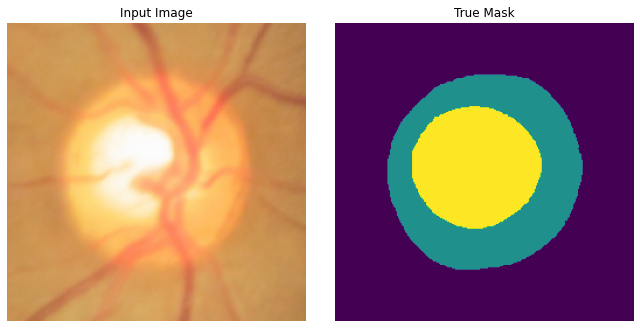

In [ ]:
for image, mask in train_dataset.shuffle(800).take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

#### Loss and Accuracy funtions


---



> - Dice loss implemented in regard to this article: [H. Sudre et al.](https://arxiv.org/pdf/1707.03237.pdf)   
> - Cup to Disc Ratio Loss (CDR Loss) was implemented by our team





In [ ]:
@tf.function
def cup_to_disc_rate_accuracy(y_true, y_pred):
    pred_mask = tf.argmax(y_pred, axis=-1)
    y_pred_disc_sum = tf.reduce_sum(tf.cast(tf.not_equal(pred_mask, 0), tf.float32), axis=[1,2])
    y_pred_cup_sum = tf.reduce_sum(tf.cast(tf.equal(pred_mask, 2), tf.float32), axis=[1,2])
    
    pred_ratio = tf.math.sqrt(tf.math.divide_no_nan(y_pred_cup_sum, y_pred_disc_sum))
    

    y_true_disc_sum = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32), axis=[1,2])[:,0]
    y_true_cup_sum = tf.reduce_sum(tf.cast(tf.equal(y_true, 2), tf.float32), axis=[1,2])[:,0]

    true_ratio = tf.math.sqrt(tf.math.divide_no_nan(y_true_cup_sum,y_true_disc_sum))


    mean_error = tf.abs(tf.subtract(pred_ratio, true_ratio))
    # print("mean_error shape", mean_error.shape)

    return 1-mean_error/BATCH_SIZE

@tf.function
def cdr_loss(y_true, y_pred):
    pred_mask = tf.argmax(y_pred, axis=-1)
    y_pred_disc_sum = tf.reduce_sum(
        tf.cast(tf.not_equal(pred_mask, 0), tf.float32), 
        axis=[1,2])
    y_pred_cup_sum = tf.reduce_sum(
        tf.cast(tf.equal(pred_mask, 2), tf.float32), 
        axis=[1,2])
    
    pred_ratio = tf.math.sqrt(
        tf.math.divide_no_nan(
            y_pred_cup_sum, 
            y_pred_disc_sum))
    

    y_true_disc_sum = tf.reduce_sum(
        tf.cast(tf.not_equal(y_true, 0), tf.float32), 
        axis=[1,2])[:,0]
    y_true_cup_sum = tf.reduce_sum(
        tf.cast(tf.equal(y_true, 2), tf.float32), 
        axis=[1,2])[:,0]

    true_ratio = tf.math.sqrt(
        tf.math.divide_no_nan(
            y_true_cup_sum, 
            y_true_disc_sum))

    error = tf.abs(tf.subtract(pred_ratio, true_ratio))
    sqrt_error = tf.reduce_sum(tf.math.sqrt(error))
    
    return sqrt_error

In [ ]:
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import backend

@tf.function
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.cast(backend.flatten(tf.one_hot(tf.cast(y_true, tf.uint8), depth=3, on_value=1, off_value=0, axis=-1)), tf.float32)
    y_pred_f = tf.cast(backend.flatten(tf.one_hot(tf.cast(tf.argmax(y_pred, -1), tf.uint8), depth=3, on_value=1, off_value=0, axis=-1)), tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * backend.sum(intersection) + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return 1. - score

@tf.function
def dice_loss_2_class(y_true, y_pred): #source: https://arxiv.org/pdf/1707.03237.pdf
    smooth = .1
    y_true_f = backend.flatten(tf.one_hot(tf.cast(y_true, tf.int32), depth=3, on_value=1., off_value=0., axis=-1, dtype=tf.float32))
    y_pred_f = backend.flatten(tf.one_hot(tf.argmax(y_pred, -1, output_type=tf.int32), depth=3, on_value=1., off_value=0., axis=-1, dtype=tf.float32))
    intersection = y_true_f * y_pred_f
    N = y_true_f.shape[0]/1.
    
    y_true_s = tf.reduce_sum(y_true_f)
    y_pred_s = tf.reduce_sum(y_pred_f)
    intersect_s = tf.reduce_sum(intersection)
    score = (intersect_s + smooth) / (y_true_s + y_pred_s + smooth) + (N - y_true_s - y_pred_s + intersect_s + smooth)/(N*2. - y_true_s - y_pred_s + smooth)
    return 1. - score

@tf.function
def scc_dice_loss(y_true, y_pred):
    #Memory?
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
    _dice_loss = dice_loss_2_class(y_true, y_pred)
    return (loss + _dice_loss) * (1. / BATCH_SIZE)

@tf.function
def scc_dice_cdr_loss(y_true, y_pred):
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            y_true, 
            y_pred, 
            from_logits=True))
    _dice_loss = dice_loss_2_class(y_true, y_pred)
    _cdr_loss = cdr_loss(y_true, y_pred)
    return (loss + _dice_loss + _cdr_loss*0.7) * (1. / BATCH_SIZE)

@tf.function
def custom_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
    _cdr_loss = cdr_loss(y_true, y_pred)
    return (loss+_cdr_loss*0.02) * (1. / BATCH_SIZE)


In [ ]:
with tpu_strategy.scope():
    model = UNet(name='Unet-efficientNet',
                width_coefficient=1.6,
                depth_coefficient=2.2,
                num_classes=3)

    model.build((1, 256, 256, 3))

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    test_loss = tf.keras.metrics.Mean(name='test_loss')

    model.compile(optimizer=tfa.optimizers.RectifiedAdam(),
                loss_fn=scc_dice_cdr_loss,
                train_loss=train_loss, test_loss=test_loss,
                metric = [cup_to_disc_rate_accuracy])



In [ ]:
#@title Define callbacks
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # text = "Epoch: {} loss: {:7.8f} val_loss: {:7.8}".format(epoch, logs["loss"], logs["val_loss"])
        # print(text)
        show_predictions()
        
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

#### Run the model using keras fit

Epoch 1/1000
321/321 [==============================] - 275s 302ms/step - loss: 0.0855 - cup_to_disc_rate_accuracy: 0.9923 - val_loss: 0.0886 - val_cup_to_disc_rate_accuracy: 0.9742


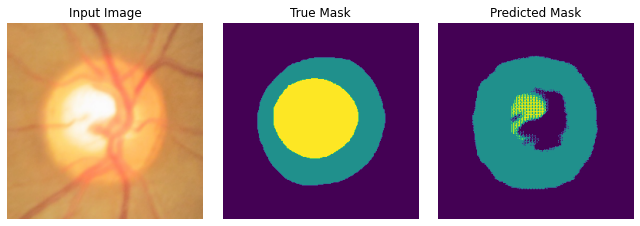

Epoch 2/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0315 - cup_to_disc_rate_accuracy: 0.9959 - val_loss: 0.1419 - val_cup_to_disc_rate_accuracy: 0.9891


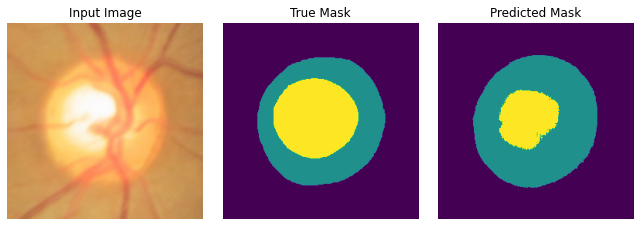

Epoch 3/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0286 - cup_to_disc_rate_accuracy: 0.9963 - val_loss: 0.1058 - val_cup_to_disc_rate_accuracy: 0.9897


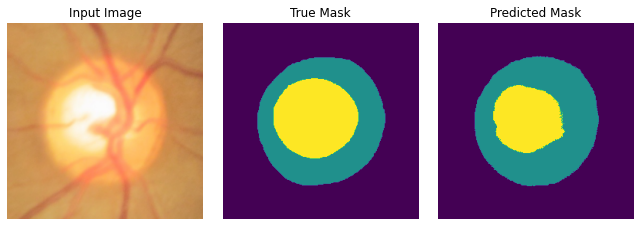

Epoch 4/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0270 - cup_to_disc_rate_accuracy: 0.9966 - val_loss: 0.0400 - val_cup_to_disc_rate_accuracy: 0.9947


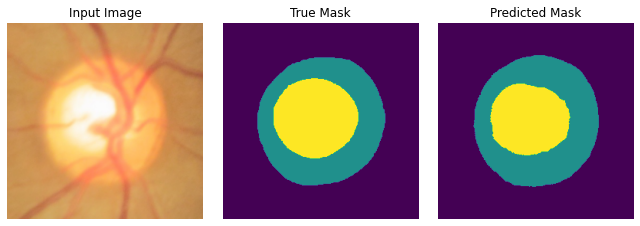

Epoch 5/1000
321/321 [==============================] - 55s 165ms/step - loss: 0.0270 - cup_to_disc_rate_accuracy: 0.9964 - val_loss: 0.0441 - val_cup_to_disc_rate_accuracy: 0.9941


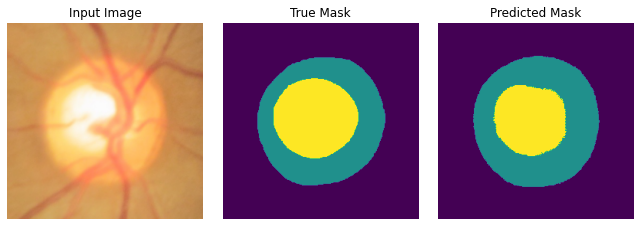

Epoch 6/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0257 - cup_to_disc_rate_accuracy: 0.9967 - val_loss: 0.0332 - val_cup_to_disc_rate_accuracy: 0.9956


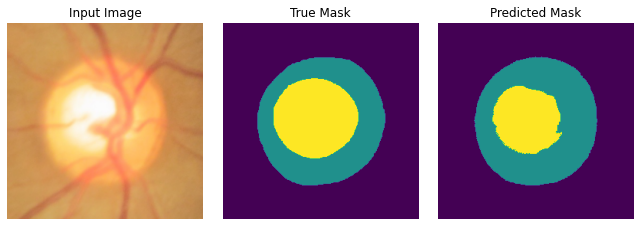

Epoch 7/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0260 - cup_to_disc_rate_accuracy: 0.9966 - val_loss: 0.0353 - val_cup_to_disc_rate_accuracy: 0.9959


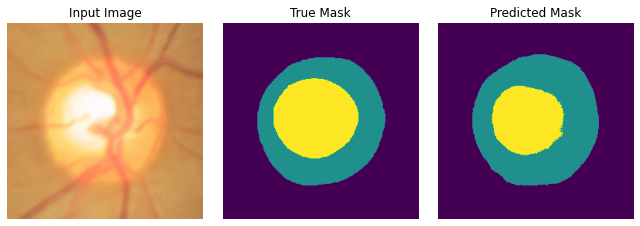

Epoch 8/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0252 - cup_to_disc_rate_accuracy: 0.9968 - val_loss: 0.0387 - val_cup_to_disc_rate_accuracy: 0.9949


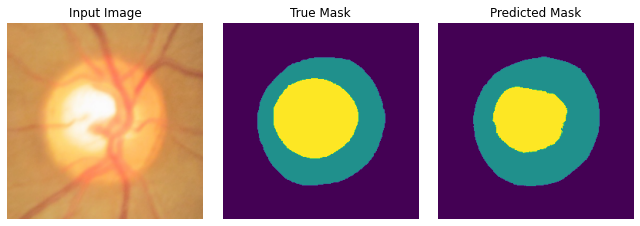

Epoch 9/1000
321/321 [==============================] - 53s 162ms/step - loss: 0.0246 - cup_to_disc_rate_accuracy: 0.9969 - val_loss: 0.0286 - val_cup_to_disc_rate_accuracy: 0.9970


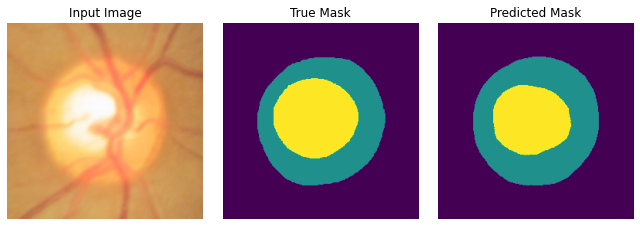

Epoch 10/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0238 - cup_to_disc_rate_accuracy: 0.9970 - val_loss: 0.0380 - val_cup_to_disc_rate_accuracy: 0.9950


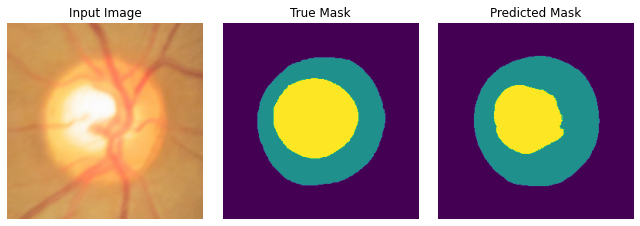

Epoch 11/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0234 - cup_to_disc_rate_accuracy: 0.9972 - val_loss: 0.0282 - val_cup_to_disc_rate_accuracy: 0.9971


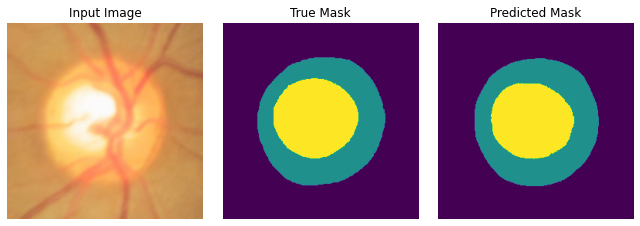

Epoch 12/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0242 - cup_to_disc_rate_accuracy: 0.9970 - val_loss: 0.0284 - val_cup_to_disc_rate_accuracy: 0.9969


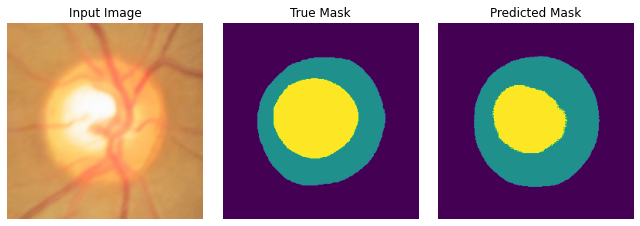

Epoch 13/1000
321/321 [==============================] - 53s 162ms/step - loss: 0.0228 - cup_to_disc_rate_accuracy: 0.9972 - val_loss: 0.0277 - val_cup_to_disc_rate_accuracy: 0.9972


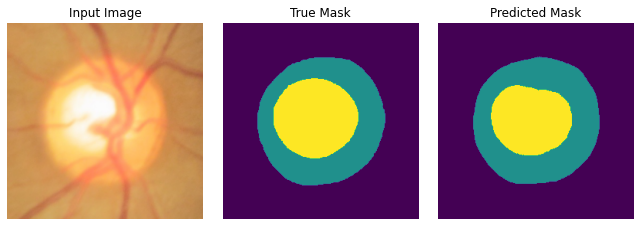

Epoch 14/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0224 - cup_to_disc_rate_accuracy: 0.9974 - val_loss: 0.0270 - val_cup_to_disc_rate_accuracy: 0.9972


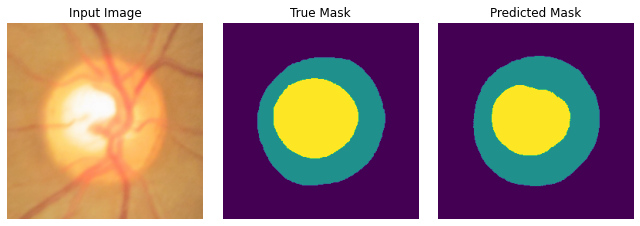

Epoch 15/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0212 - cup_to_disc_rate_accuracy: 0.9976 - val_loss: 0.0270 - val_cup_to_disc_rate_accuracy: 0.9973


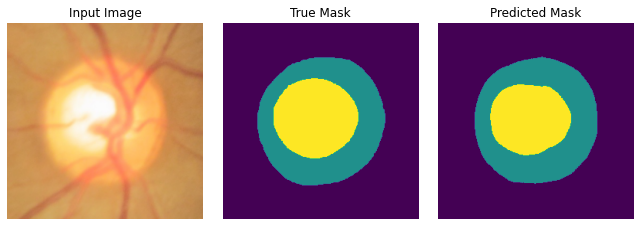

Epoch 16/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0214 - cup_to_disc_rate_accuracy: 0.9976 - val_loss: 0.0297 - val_cup_to_disc_rate_accuracy: 0.9972


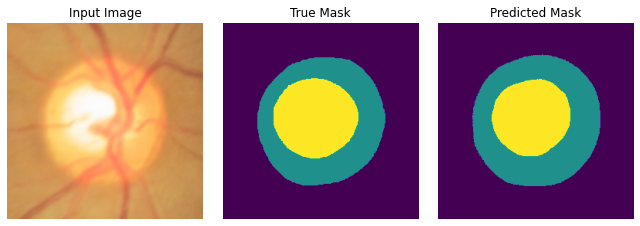

Epoch 17/1000
321/321 [==============================] - 53s 161ms/step - loss: 0.0199 - cup_to_disc_rate_accuracy: 0.9979 - val_loss: 0.0293 - val_cup_to_disc_rate_accuracy: 0.9969


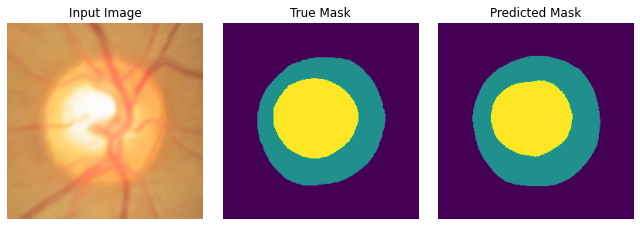

Epoch 18/1000
321/321 [==============================] - 54s 165ms/step - loss: 0.0192 - cup_to_disc_rate_accuracy: 0.9980 - val_loss: 0.0264 - val_cup_to_disc_rate_accuracy: 0.9971


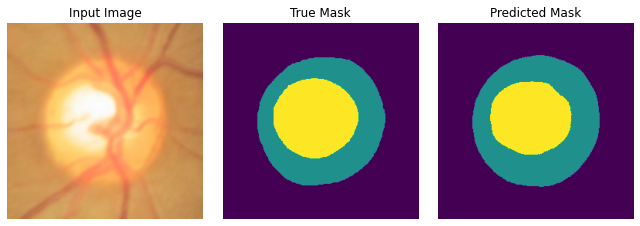

Epoch 19/1000
321/321 [==============================] - 55s 167ms/step - loss: 0.0183 - cup_to_disc_rate_accuracy: 0.9981 - val_loss: 0.0252 - val_cup_to_disc_rate_accuracy: 0.9974


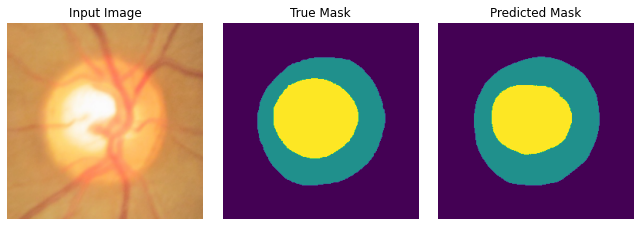

Epoch 20/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0184 - cup_to_disc_rate_accuracy: 0.9981 - val_loss: 0.0273 - val_cup_to_disc_rate_accuracy: 0.9973


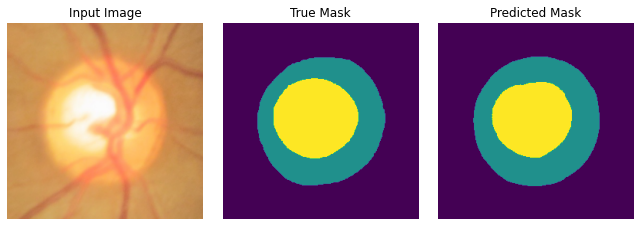

Epoch 21/1000
321/321 [==============================] - 54s 165ms/step - loss: 0.0171 - cup_to_disc_rate_accuracy: 0.9984 - val_loss: 0.0263 - val_cup_to_disc_rate_accuracy: 0.9975


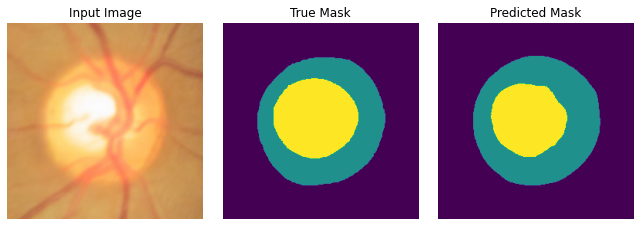

Epoch 22/1000
321/321 [==============================] - 54s 165ms/step - loss: 0.0161 - cup_to_disc_rate_accuracy: 0.9986 - val_loss: 0.0300 - val_cup_to_disc_rate_accuracy: 0.9970


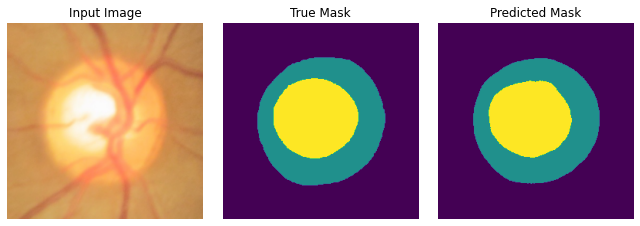

Epoch 23/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0160 - cup_to_disc_rate_accuracy: 0.9986 - val_loss: 0.0276 - val_cup_to_disc_rate_accuracy: 0.9973


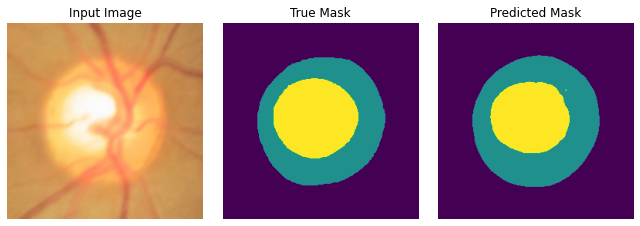

Epoch 24/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0157 - cup_to_disc_rate_accuracy: 0.9986 - val_loss: 0.0272 - val_cup_to_disc_rate_accuracy: 0.9972


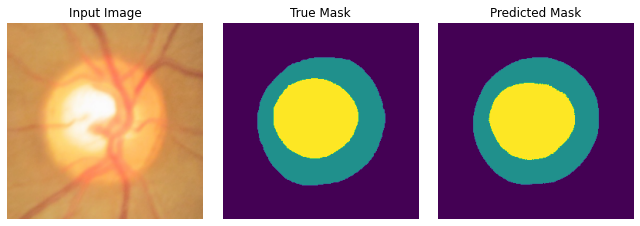

Epoch 25/1000
321/321 [==============================] - 53s 161ms/step - loss: 0.0152 - cup_to_disc_rate_accuracy: 0.9987 - val_loss: 0.0284 - val_cup_to_disc_rate_accuracy: 0.9971


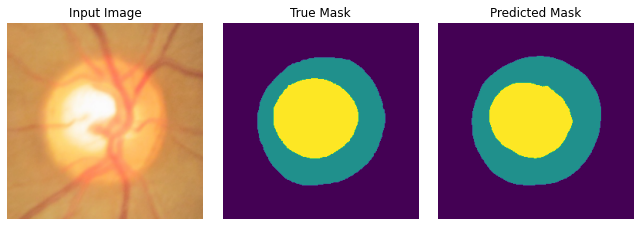

Epoch 26/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0145 - cup_to_disc_rate_accuracy: 0.9988 - val_loss: 0.0282 - val_cup_to_disc_rate_accuracy: 0.9973


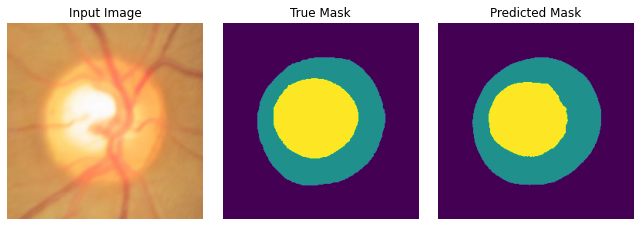

Epoch 27/1000
321/321 [==============================] - 54s 163ms/step - loss: 0.0137 - cup_to_disc_rate_accuracy: 0.9989 - val_loss: 0.0274 - val_cup_to_disc_rate_accuracy: 0.9973


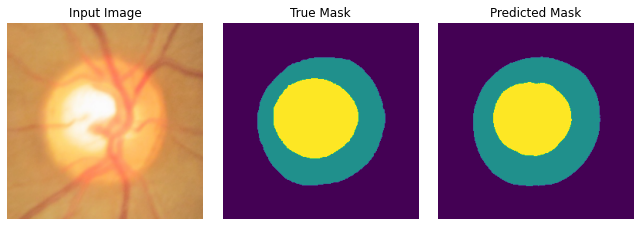

Epoch 28/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0130 - cup_to_disc_rate_accuracy: 0.9990 - val_loss: 0.0287 - val_cup_to_disc_rate_accuracy: 0.9972


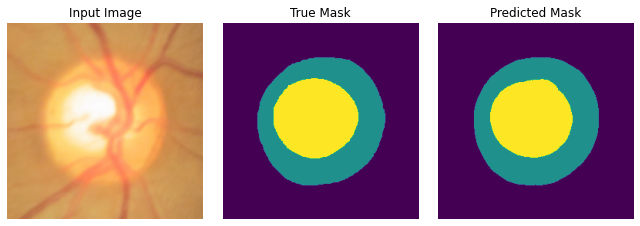

Epoch 29/1000
321/321 [==============================] - 53s 161ms/step - loss: 0.0127 - cup_to_disc_rate_accuracy: 0.9990 - val_loss: 0.0289 - val_cup_to_disc_rate_accuracy: 0.9973


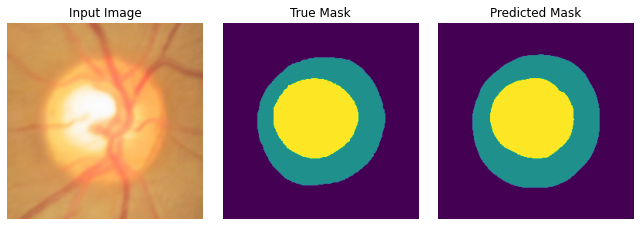

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


In [ ]:
EPOCHS = 1000

model_history = model.fit(train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                          epochs=EPOCHS,
                          validation_data=validation_dataset.batch(BATCH_SIZE, drop_remainder=True),
                          callbacks=[DisplayCallback(), early_stopping])

In [ ]:
# !mkdir ./drive/MyDrive/cup-to-disc-models/unet-v1/weights

model.save_weights("./drive/MyDrive/cup-to-disc-models/unet-v1/weights/checkpoint", save_format="h5")

#### Test Dataset

In [ ]:
from PIL import Image

In [ ]:
sample_im = sample_im.resize((256,256))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def get_threshold(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]
    return sensitivity, specificity, optimal_threshold, auc_score

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from PIL import ImageOps

In [ ]:
im_root = './drive/MyDrive/Datasets/Glaucoma/normal_cropped'
im_names = os.listdir(im_root)
preds_normal = []
for im_name in tqdm(im_names):
    im = Image.open(f"{im_root}/{im_name}").resize((256,256))
    im = ImageOps.equalize(im)
    pred = model.predict(np.array(im)[tf.newaxis,...].astype('float32')/255)

    pred_mask = create_mask(pred)[...,0].numpy()
    disc_px_count = np.sum(pred_mask > 0)
    cup_px_count = np.sum(pred_mask > 1)

    preds_normal.append([disc_px_count, cup_px_count, im_name])
    

In [ ]:
im_root = './drive/MyDrive/Datasets/Glaucoma/glc_cropped'
im_names = os.listdir(im_root)
preds_glc = []
for im_name in tqdm(im_names):
    im = Image.open(f"{im_root}/{im_name}").resize((256,256))
    im = ImageOps.equalize(im)
    pred = model.predict(np.array(im)[tf.newaxis,...].astype('float32')/255)

    pred_mask = create_mask(pred)[...,0].numpy()
    disc_px_count = np.sum(pred_mask > 0)
    cup_px_count = np.sum(pred_mask > 1)

    preds_glc.append([disc_px_count, cup_px_count, im_name])
    

In [ ]:
glc_df = pd.DataFrame(preds_glc, columns=['disc_px_count', 'cup_px_count', 'im_name'])
nor_df = pd.DataFrame(preds_normal, columns=['disc_px_count', 'cup_px_count', 'im_name'])


#### Plots

#### Fine-tune Trained model with histogram streching


In [ ]:
"""
Process had to be defined with tensorflow scope since it is gonna be used in tpu after parsed to xla
"""
@tf.function
def tf_strech_histogram(image, *args):
    rmax = tf.reduce_max(image, axis=[-3,-2])
    rmin = tf.reduce_min(image, axis=[-3,-2])
    return ((image-rmin)/(rmax-rmin), *args)

train_dataset_v2 = train_dataset.map(tf_strech_histogram, num_parallel_calls=AUTO)
validation_dataset_v2 = validation_dataset.map(tf_strech_histogram, num_parallel_calls=AUTO)

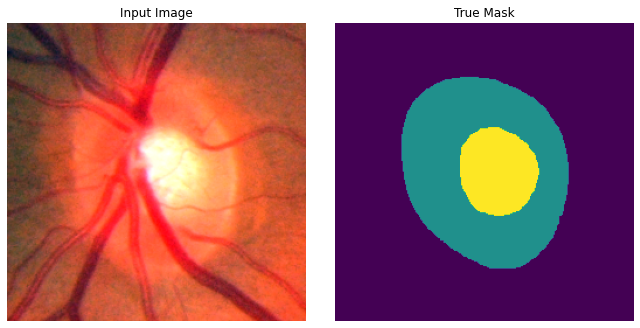

In [ ]:
for image, mask in train_dataset_v2.shuffle(800).take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

Epoch 1/1000
321/321 [==============================] - 55s 167ms/step - loss: 0.0200 - cup_to_disc_rate_accuracy: 0.9977 - val_loss: 0.0256 - val_cup_to_disc_rate_accuracy: 0.9973


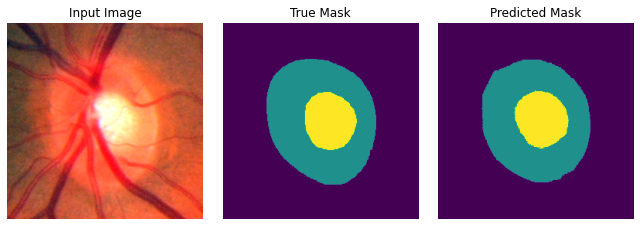

Epoch 2/1000
321/321 [==============================] - 55s 167ms/step - loss: 0.0189 - cup_to_disc_rate_accuracy: 0.9981 - val_loss: 0.0298 - val_cup_to_disc_rate_accuracy: 0.9969


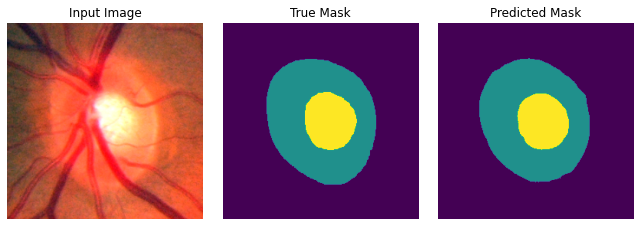

Epoch 3/1000
321/321 [==============================] - 54s 166ms/step - loss: 0.0171 - cup_to_disc_rate_accuracy: 0.9984 - val_loss: 0.0297 - val_cup_to_disc_rate_accuracy: 0.9967


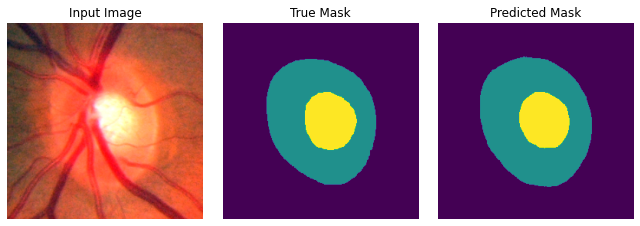

Epoch 4/1000
321/321 [==============================] - 55s 166ms/step - loss: 0.0160 - cup_to_disc_rate_accuracy: 0.9985 - val_loss: 0.0269 - val_cup_to_disc_rate_accuracy: 0.9973


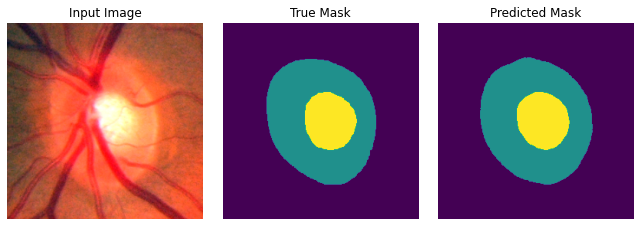

Epoch 5/1000
321/321 [==============================] - 55s 166ms/step - loss: 0.0153 - cup_to_disc_rate_accuracy: 0.9985 - val_loss: 0.0263 - val_cup_to_disc_rate_accuracy: 0.9975


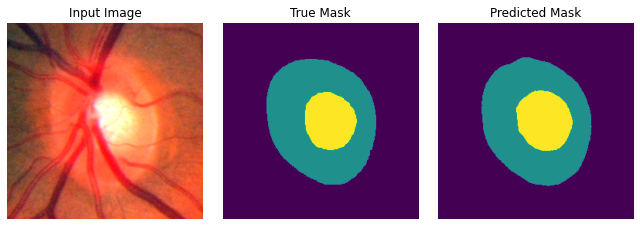

Epoch 6/1000
321/321 [==============================] - 55s 166ms/step - loss: 0.0152 - cup_to_disc_rate_accuracy: 0.9986 - val_loss: 0.0275 - val_cup_to_disc_rate_accuracy: 0.9973


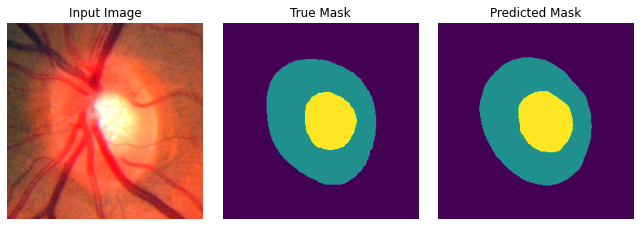

Epoch 7/1000
321/321 [==============================] - 55s 167ms/step - loss: 0.0143 - cup_to_disc_rate_accuracy: 0.9988 - val_loss: 0.0282 - val_cup_to_disc_rate_accuracy: 0.9972


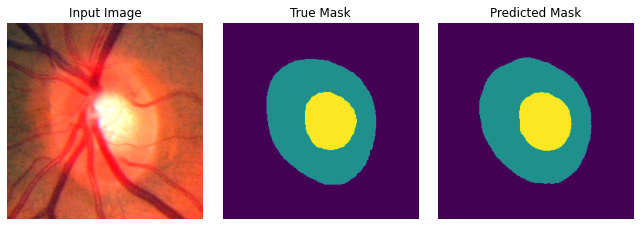

Epoch 8/1000
321/321 [==============================] - 55s 166ms/step - loss: 0.0139 - cup_to_disc_rate_accuracy: 0.9989 - val_loss: 0.0286 - val_cup_to_disc_rate_accuracy: 0.9971


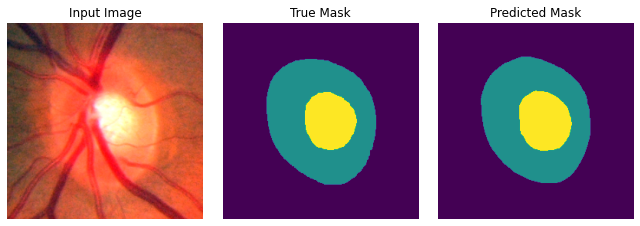

Epoch 9/1000
321/321 [==============================] - 55s 165ms/step - loss: 0.0129 - cup_to_disc_rate_accuracy: 0.9990 - val_loss: 0.0286 - val_cup_to_disc_rate_accuracy: 0.9972


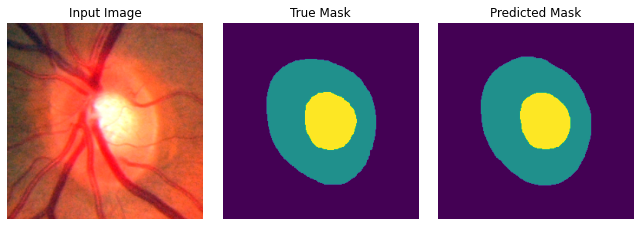

Epoch 10/1000
321/321 [==============================] - 54s 164ms/step - loss: 0.0124 - cup_to_disc_rate_accuracy: 0.9991 - val_loss: 0.0276 - val_cup_to_disc_rate_accuracy: 0.9974


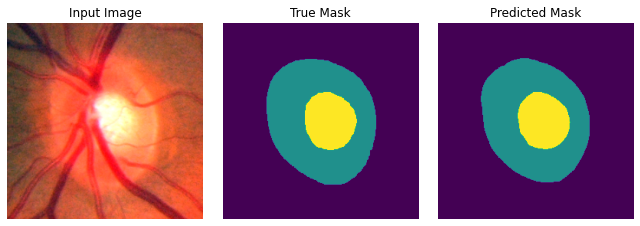

Epoch 11/1000
321/321 [==============================] - 54s 165ms/step - loss: 0.0121 - cup_to_disc_rate_accuracy: 0.9991 - val_loss: 0.0278 - val_cup_to_disc_rate_accuracy: 0.9974


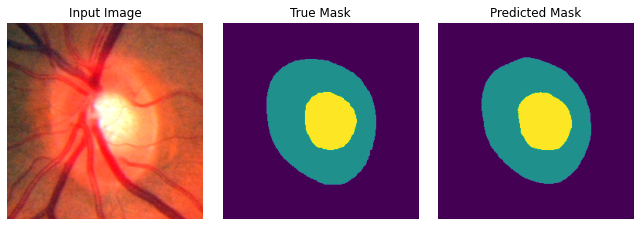

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


In [ ]:
model_history_2 = model.fit(train_dataset_v2.batch(BATCH_SIZE, drop_remainder=True),
                          epochs=EPOCHS,
                          validation_data=validation_dataset_v2.batch(BATCH_SIZE, drop_remainder=True),
                          callbacks=[DisplayCallback(), early_stopping])

In [ ]:
!mkdir ./drive/MyDrive/cup-to-disc-models/unet-v2/weights

model.save_weights("./drive/MyDrive/cup-to-disc-models/unet-v2/weights/checkpoint", save_format="h5")

In [ ]:
#@title Before hist stretch training
pd.DataFrame(data).T

Before hist stretch training


sensitivity  specificity  ...  auc_score  valid_count
histogram_streching     0.801047     0.802198  ...   0.845780        373.0
pure                    0.839080     0.788571  ...   0.858654        349.0
hist_eq                 0.409326     0.756757  ...   0.587201        378.0

[3 rows x 5 columns]

In [ ]:
im_root = './drive/MyDrive/Datasets/Glaucoma/normal_cropped'
im_names = os.listdir(im_root)
preds_normal = []
for im_name in tqdm(im_names):
    im = Image.open(f"{im_root}/{im_name}").resize((256,256))
    im = ImageOps.autocontrast(im)
    pred = model.predict(np.array(im)[tf.newaxis,...].astype('float32')/255)

    pred_mask = create_mask(pred)[...,0].numpy()
    disc_px_count = np.sum(pred_mask > 0)
    cup_px_count = np.sum(pred_mask > 1)

    preds_normal.append([disc_px_count, cup_px_count, im_name])


im_root = './drive/MyDrive/Datasets/Glaucoma/glc_cropped'
im_names = os.listdir(im_root)
preds_glc = []
for im_name in tqdm(im_names):
    im = Image.open(f"{im_root}/{im_name}").resize((256,256))
    im = ImageOps.autocontrast(im)
    pred = model.predict(np.array(im)[tf.newaxis,...].astype('float32')/255)

    pred_mask = create_mask(pred)[...,0].numpy()
    disc_px_count = np.sum(pred_mask > 0)
    cup_px_count = np.sum(pred_mask > 1)

    preds_glc.append([disc_px_count, cup_px_count, im_name])


In [ ]:
df

sensitivity  specificity  ...  accuracy  valid_perc
hist_eq                    0.409326     0.756757  ...  0.567358    0.979275
v2_pure                    0.801105     0.759563  ...  0.764592    0.943005
v2_hist_eq                 0.736842     0.804348  ...  0.753925    0.968912
histogram_streching        0.801047     0.802198  ...  0.784997    0.966321
pure                       0.839080     0.788571  ...  0.797482    0.904145
v2_histogram_streching     0.863874     0.771739  ...  0.801812    0.971503

[6 rows x 7 columns]